# 뉴스 카테고리 다중분류

## 프로젝트: Vocabulary Size를 변경해서 시도해보기

### 학습 목표
이번 시간의 목표입니다.

로이터 뉴스 데이터 이해하기

F1-score와 confusion matrix 출력해보기

여러 머신러닝 모델에 대해서 성능 비교해보기

단어 수에 따른 성능 비교해보기

In [ ]:
# 필요한 모듈 임포트하기
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

## 데이터 불러오기 및 분석, 전처리
### 모든 단어 사용
실험을 위해 데이터셋의 모든 단어를 사용한다.

해당 데이터셋은 정수 시퀀스로 변환되어 제공된다고 한다.

In [ ]:
# 로이터 뉴스 데이터 받아오기
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2) # 상위 10000개 아니고 모든 데이터 가져오려고 none 사용하는듯하다

2121728/2110848 [==============================] - 0s 0us/step


In [ ]:
# 데이터 구성 출력 해보기
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


In [ ]:
# 클래스의 수 확인하기
num_classes = max(y_train) + 1 # 모든 레이블 중 최댓값을 구하고 1을 더하면 현재 클래스의 개수를 확인할 수 있다.
print('클래스의 수 : {}'.format(num_classes))

클래스의 수 : 46


훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


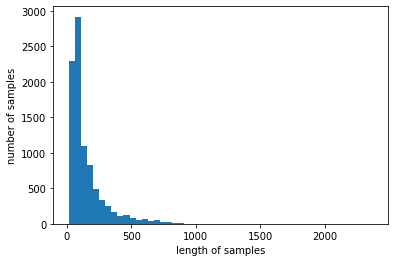

In [ ]:
# 뉴스 데이터 길이 분포 확인해보기
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train)) / len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
# 로이터 뉴스 데이터는 '단어'를 key값으로, 고유한 '정수'를 value로 가지는 dictionary를 제공하는데 이를 word_index로 저장했다
word_index = reuters.get_word_index(path="reuters_word_index.json")

565248/550378 [==============================] - 0s 0us/step


In [ ]:
# reuters.get_word_index에는 실제 단어에 맵핑 한 정수에 -3을 한 정수를 입력해 놓았기 때문에 word_index에서 index_word를 만들 때, 각 정수에 +3을 해주어야한다
index_to_word = {index + 3 : word for word, index in word_index.items()}

In [ ]:
# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
# 0,1,2,번은 자연어 처리를 위한 특별한 토큰들을 위해 맵핑된 번호이다. 그래서 만들어진 index_to_word에 추가적으로 이 작업을 해주어야 index_to_word가 완성된다
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

In [ ]:
# 0번째 샘플로 확인
x_train[0]

[1,
 27595,
 28842,
 8,
 43,
 10,
 447,
 5,
 25,
 207,
 270,
 5,
 3095,
 111,
 16,
 369,
 186,
 90,
 67,
 7,
 89,
 5,
 19,
 102,
 6,
 19,
 124,
 15,
 90,
 67,
 84,
 22,
 482,
 26,
 7,
 48,
 4,
 49,
 8,
 864,
 39,
 209,
 154,
 6,
 151,
 6,
 83,
 11,
 15,
 22,
 155,
 11,
 15,
 7,
 48,
 9,
 4579,
 1005,
 504,
 6,
 258,
 6,
 272,
 11,
 15,
 22,
 134,
 44,
 11,
 15,
 16,
 8,
 197,
 1245,
 90,
 67,
 52,
 29,
 209,
 30,
 32,
 132,
 6,
 109,
 15,
 17,
 12]

In [ ]:
# index_to_word를 통해 첫번째 훈련용 뉴스 기사를 텍스트로 복원해보기
print(' '.join([index_to_word[index] for index in x_train[0]]))

<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


### 전체 데이터 변환(train, test)

전체 훈련용 뉴스 데이터와 전체 테스트용 뉴스 데이터를 텍스트 데이터로 변환해보자

In [ ]:
decoded = []
for i in range(len(x_train)):
  t = ' '.join([index_to_word[index] for index in x_train[i]])
  decoded.append(t)

x_train = decoded

In [ ]:
decoded = []
for i in range(len(x_test)):
  t = ' '.join([index_to_word[index] for index in x_test[i]])
  decoded.append(t)

x_test = decoded

## 벡터화 하기
Document Term Matrix, DTM을 활용한 TF-IDF행렬로 벡터화한다.

In [ ]:
# 필요한 도구 임포트
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [ ]:
# DTM 생성하고 크기 확인해보기
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 26506)


In [ ]:
# TF-IDF 생성하고 크기 확인해보기
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 26506)


## 머신러닝 모델 학습
### 나이브 베이즈 분류기

In [ ]:
# 사용할 다양한 머신러닝 모델 라이브러리
from sklearn.naive_bayes import MultinomialNB # 다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score # 정확도 계산

In [ ]:
# 필요한 라이브러리 불러오기
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
# 테스트 데이터에 대한 정확도를 측정하기 위해서는 훈련 데이터와 동일한 전처리를 거쳐야 한다. 테스트 데이터도 TF-IDF행렬로 변환한다
x_test_dtm = dtmvector.transform(x_test) # 테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF_IDF 행렬로 변환

In [ ]:
# 다양한 머신러닝 모델 사용해보기

def train_ml(tfidfv, y_train, tfidfv_test, y_test):
  # 나이브 베이즈 분류기
  mod = MultinomialNB()
  mod.fit(tfidfv, y_train)

  mod_predicted = mod.predict(tfidfv_test) # 테스트 데이터에 대한 예측
  print("나이브 베이즈 정확도:", accuracy_score(y_test, mod_predicted)) # 예측값과 실제값 비교

  # CNB
  cb = ComplementNB()
  cb.fit(tfidfv, y_train)

  cb_predicted = cb.predict(tfidfv_test) # 테스트 데이터에 대한 예측
  print("CNB 정확도:", accuracy_score(y_test, cb_predicted)) # 예측값과 실제값 비교

  # 로지스틱 회귀
  lr = LogisticRegression(C=10000, penalty='l2')
  lr.fit(tfidfv, y_train)

  lr_predicted = lr.predict(tfidfv_test) # 테스트 데이터에 대한 예측
  print("로지스틱 회귀 정확도:", accuracy_score(y_test, lr_predicted)) # 예측값과 실제값 비교

  # 선형 서포트 벡터 머신
  lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
  lsvc.fit(tfidfv, y_train)

  lsvc_predicted = lsvc.predict(tfidfv_test) # 테스트 데이터에 대한 예측
  print("SVM 정확도:", accuracy_score(y_test, lsvc_predicted)) # 예측값과 실제값 비교

  # 결정 트리(Decision Tree)
  tree = DecisionTreeClassifier(max_depth=10, random_state=0)
  tree.fit(tfidfv, y_train)

  tree_predicted = tree.predict(tfidfv_test) # 테스트 데이터에 대한 예측
  print("결정 트리 정확도:", accuracy_score(y_test, tree_predicted)) # 예측값과 실제값 비교

  # 랜덤 포레스트(Random Forset)
  forest = RandomForestClassifier(n_estimators=5, random_state=0)
  forest.fit(tfidfv, y_train)

  forest.fit(tfidfv, y_train)

  forest_predicted =forest.predict(tfidfv_test) # 테스트 데이터에 대한 예측
  print("랜덤 포레스트 정확도:", accuracy_score(y_test, forest_predicted)) # 예측값과 실제값 비교

  # 그래디언트 부스팅 트리(GradientBoostingClassifier)
  grbt = GradientBoostingClassifier(random_state=0, verbose=3) # verbose=3
  grbt.fit(tfidfv, y_train)

  grbt_predicted = grbt.predict(tfidfv_test) # 테스트 데이터에 대한 예측
  print("그래디언트 부스팅 트리 정확도:", accuracy_score(y_test, grbt_predicted)) # 예측값과 실제값 비교

  # 보팅(Voting)
  voting_classifier = VotingClassifier(estimators=[
                                                  ('lr', LogisticRegression(C=10000, penalty='l2')),
                                                  ('cb', ComplementNB()),
                                                  ('grbt', GradientBoostingClassifier(random_state=0))
                                                  ], voting='soft', n_jobs=-1)
  voting_classifier.fit(tfidfv, y_train)

  voting_classifier_predicted = voting_classifier.predict(tfidfv_test) # 테스트 데이터에 대한 예측
  print("보팅 정확도", accuracy_score(y_test, voting_classifier_predicted)) # 예측값과 실제값 비교

  return mod, cb, lr, lsvc, tree, forest, grbt, voting_classifier

In [ ]:
mod, cb, lr, lsvb, tree, forest, grbt, voting_classifier = train_ml(tfidfv, y_train, tfidfv_test, y_test)

나이브 베이즈 정확도: 0.5997328584149599
CNB 정확도: 0.7649154051647373


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


로지스틱 회귀 정확도: 0.813446126447017


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


SVM 정확도: 0.7782724844167409
결정 트리 정확도: 0.6211041852181657
랜덤 포레스트 정확도: 0.6544968833481746
      Iter       Train Loss   Remaining Time 
         1           1.4301           15.43m
         2       76760.8864           15.58m
         3   766490025.2967           15.47m
         4 660857139232122368.0000           15.27m
         5 1006529060407114004275646732312951615311370376755613476759245377256674837692003341988813591601665584394912965173495998495951159296.0000           15.16m
         6 1006529060407114004275646732312951615311370376755613476759245377256674837692003341988813591601665584394912965173495998495951159296.0000           14.98m
         7 1006529060407114004275646732312951615311370376755613476759245377256674837692003341988813591601665584394912965173495998495951159296.0000           14.82m
         8 1006529060407114004275646732312951615311370376755613476759245377256674837692003341988813591601665584394912965173495998495951159296.0000           14.65m
         9 1006529060

##  Vocabulary Size를 변경해서 시도해보기
### 단어 5000개 사용

In [ ]:
(x_train_5k, y_train_5k), (x_test_5k, y_test_5k) = reuters.load_data(num_words=5000, test_split=0.2)

In [ ]:
decoded = []
for i in range(len(x_train_5k)):
  t = ' '.join([index_to_word[index] for index in x_train_5k[i]])
  decoded.append(t)

x_train_5k = decoded

In [ ]:
decoded = []
for i in range(len(x_test_5k)):
  t = ' '.join([index_to_word[index] for index in x_test_5k[i]])
  
  decoded.append(t)

x_test_5k = decoded

In [ ]:
dtmvector = CountVectorizer()
x_train_dtm_5k = dtmvector.fit_transform(x_train_5k)
print(x_train_dtm_5k.shape)

(8982, 4867)


In [ ]:
tfidf_transformer = TfidfTransformer()
tfidfv_5k = tfidf_transformer.fit_transform(x_train_dtm_5k)
print(tfidfv_5k.shape)

(8982, 4867)


In [ ]:
x_test_dtm_5k = dtmvector.transform(x_test_5k) # 테스트 데이터를 DTM으로 변환
tfidfv_test_5k = tfidf_transformer.transform(x_test_dtm_5k) # DTM을 TF-IDF 행렬로 변환

In [ ]:
import time
start = time.time()

mod_5k, cb_5k, lr_5k, lsvc_5, tree_5k, forest_5k, grbt_5k, voting_classifier_5k = train_ml(tfidfv_5k, y_train_5k, tfidfv_test_5k, y_test_5k)

print("time : ", time.time() - start)

나이브 베이즈 정확도: 0.6731967943009796
CNB 정확도: 0.7707034728406055


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


로지스틱 회귀 정확도: 0.8058771148708815


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


SVM 정확도: 0.7600178094390027
결정 트리 정확도: 0.6179875333926982
랜덤 포레스트 정확도: 0.701246660730187
      Iter       Train Loss   Remaining Time 
         1           1.4697           13.74m
         2     2131099.0239           13.76m
         3 113352934366748750033493137947714414201794552363528671409179356940992512.0000           13.68m
         4 645005367195105573487290209089081189090170195029150070319832395667206596719018218881024.0000           13.59m
         5 443067299530301659980374363525949995629695549691559890285869350923592723545213280554158712204202745088665306932510573934053386280801140736.0000           13.49m
         6 443067299530301659980374363525949995629695549691559890285869350923592723545213280554158712204202745088665306932510573934053386280801140736.0000           13.37m
         7 443067299530301659980374363525949995629695549691559890285869350923592723545213280554158712204202745088665306932510573934053386280801140736.0000           13.22m
         8 443067299530301659980

### 단어 1000개 사용

In [ ]:
(x_train_1k, y_train_1k), (x_test_1k, y_test_1k) = reuters.load_data(num_words=1000, test_split=0.2)

In [ ]:
decoded = []
for i in range(len(x_train_1k)):
  t = ' '.join([index_to_word[index] for index in x_train_1k[i]])
  decoded.append(t)

x_train_1k = decoded

In [ ]:
decoded = []
for i in range(len(x_test_1k)):
  t = ' '.join([index_to_word[index] for index in x_test_1k[i]])
  decoded.append(t)

x_test_1k = decoded

In [ ]:
dtmvector = CountVectorizer()
x_train_dtm_1k = dtmvector.fit_transform(x_train_1k)
print(x_train_dtm_1k.shape)

(8982, 969)


In [ ]:
tfidf_transformer = TfidfTransformer()
tfidfv_1k = tfidf_transformer.fit_transform(x_train_dtm_1k)
print(tfidfv_1k.shape)

(8982, 969)


In [ ]:
x_test_dtm_1k = dtmvector.transform(x_test_1k) # 테스트 데이터를 DTM으로 변환
tfidfv_test_1k = tfidf_transformer.transform(x_test_dtm_1k) # DTM을 TF_IDF 행렬로 변환

In [ ]:
import time
import datetime

start = time.time()

mod_1k, cb_1k, lr_1k, lsvc_1k, tree_1k, forest_1k, grbt_1k, voting_classifier_1k = train_ml(tfidfv_1k, y_train_1k, tfidfv_test_1k, y_test_1k)

sec = time.time()-start
times = str(datetime.timedelta(seconds=sec)).split(".")
times = times[0]
print('run time : ', times)

나이브 베이즈 정확도: 0.6856634016028496
CNB 정확도: 0.7346393588601959


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


로지스틱 회귀 정확도: 0.780053428317008


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


SVM 정확도: 0.719946571682992
결정 트리 정확도: 0.6179875333926982
랜덤 포레스트 정확도: 0.707479964381122
      Iter       Train Loss   Remaining Time 
         1           1.5717           11.49m
         2        3967.8426           11.47m
         3        4754.6181           11.37m
         4     1016060.1416           11.25m
         5     1016079.3289           11.17m
         6     6974797.9520           11.05m
         7     6974845.8927           10.95m
         8     6974845.8761           10.84m
         9 67711611000699444040275566464186667477192234919406304097104172655300731568078356217856.0000           10.73m
        10 67711611000699444040275566464186667477192234919406304097104172655300731568078356217856.0000           10.61m
        11 67711611000699444040275566464186667477192234919406304097104172655300731568078356217856.0000           10.49m
        12 67711611000699444040275566464186667477192234919406304097104172655300731568078356217856.0000           10.38m
        13 677116110006994

### 단어 10000개 사용

In [ ]:
(x_train_10k, y_train_10k), (x_test_10k, y_test_10k) = reuters.load_data(num_words=10000, test_split=0.2)

In [ ]:
decoded =[]
for i in range(len(x_train_10k)):
  t = ' '.join([index_to_word[index] for index in x_train_10k[i]])
  decoded.append(t)

x_train_10k = decoded

In [ ]:
decoded = []
for i in range(len(x_test_10k)):
  t = ' '.join([index_to_word[index] for index in x_test_10k[i]])
  decoded.append(t)

x_test_10k = decoded

In [ ]:
dtmvector = CountVectorizer()
x_train_dtm_10k = dtmvector.fit_transform(x_train_10k)
print(x_train_dtm_10k.shape)

(8982, 9670)


In [ ]:
tfidf_transformer = TfidfTransformer()
tfidfv_10k = tfidf_transformer.fit_transform(x_train_dtm_10k)
print(tfidfv_10k.shape)

(8982, 9670)


In [ ]:
x_test_dtm_10k = dtmvector.transform(x_test_10k) # 테스트 데이터를 DTM으로 변환
tfidfv_test_10k = tfidf_transformer.transform(x_test_dtm_10k) # DTM을 TF-IDF 행렬로 변환

In [ ]:
start  = time.time()

mod_10k, cb_10k, lr_10k, lsvc_10k, tree_10k, forest_10k, grbt_10k, voting_classifier_10k = train_ml(tfidfv_10k, y_train_10k, tfidfv_test_10k, y_test_10k)

sec = time.time()-start
times = str(datetime.timedelta(seconds=sec)).split(".")
times = times[0]
print('run time :', times)

나이브 베이즈 정확도: 0.6567230632235085
CNB 정확도: 0.7707034728406055


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


로지스틱 회귀 정확도: 0.8076580587711487


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


SVM 정확도: 0.7729296527159395
결정 트리 정확도: 0.6202137132680321
랜덤 포레스트 정확도: 0.674087266251113
      Iter       Train Loss   Remaining Time 
         1           1.4608           14.65m
         2       95544.1548           14.69m
         3      105411.1055           14.57m
         4 26490374809120059619893320924222374741943986946048.0000           14.44m
         5 3332464259228453694671945105465820387521328203545526380221295913764842145866429631276902168311601749602693928777633481065758720.0000           14.26m
         6 3332464259228453694671945105465820387521328203545526380221295913764842145866429631276902168311601749602693928777633481065758720.0000           14.11m
         7 3332464259228453694671945105465820387521328203545526380221295913764842145866429631276902168311601749602693928777633481065758720.0000           13.99m
         8 3332464259228453694671945105465820387521328203545526380221295913764842145866429631276902168311601749602693928777633481065758720.0000           13.83m
  

### 단어 20000개 사용

In [ ]:
(x_train_20k, y_train_20k), (x_test_20k, y_test_20k) = reuters.load_data(num_words=20000, test_split=0.2)

In [ ]:
decoded = []
for i in range(len(x_train_20k)):
  t = ' '.join([index_to_word[index] for index in x_train_20k[i]])
  decoded.append(t)

x_train_20k = decoded

In [ ]:
decoded = []
for i in range(len(x_test_20k)):
  t =' '.join([index_to_word[index] for index in x_test_20k[i]])
  decoded.append(t)

x_test_20k = decoded

In [ ]:
dtmvector = CountVectorizer()
x_train_dtm_20k = dtmvector.fit_transform(x_train_20k)
print(x_train_dtm_20k.shape)

(8982, 18479)


In [ ]:
tfidf_transformer = TfidfTransformer()
tfidfv_20k = tfidf_transformer.fit_transform(x_train_dtm_20k)
print(tfidfv_20k.shape)

(8982, 18479)


In [ ]:
x_test_dtm_20k = dtmvector.transform(x_test_20k) # 테스트 데이터를 DTM으로 변환
tfidfv_test_20k = tfidf_transformer.transform(x_test_dtm_20k) # DTM을 TF-IDF 행렬로 변환

In [ ]:
start = time.time()

mod_20k, cb_20k, lr_20k, lsvc_20k, tree_20k, forest_20k, grbt_20k, voting_classifier_20k = train_ml(tfidfv_20k, y_train_20k, tfidfv_test_20k, y_test_20k)

sec = time.time()-start
times = str(datetime.timedelta(seconds=sec)).split(".")
times = times[0]
print('run time :', times)

나이브 베이즈 정확도: 0.6193232413178985
CNB 정확도: 0.7671415850400712


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


로지스틱 회귀 정확도: 0.8098842386464826


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


SVM 정확도: 0.7733748886910062
결정 트리 정확도: 0.6211041852181657
랜덤 포레스트 정확도: 0.6714158504007124
      Iter       Train Loss   Remaining Time 
         1           1.4325           15.17m
         2       95425.3579           15.37m
         3      105570.6041           15.36m
         4 593224062708261760.0000           15.21m
         5 3774435173865725234928276254753926961504996704196152337310417818266040513071397885183910310310561420723401279705159106767064399872.0000           15.12m
         6 3774435173865725234928276254753926961504996704196152337310417818266040513071397885183910310310561420723401279705159106767064399872.0000           14.96m
         7 1489548745818530758244232012042654711502171239857813292906777294351633452202689035463067802524827847410009904379930627599745172362994401857765376.0000           14.78m
         8 1489548745818530758244232012042654711502171239857813292906777294351633452202689035463067802524827847410009904379930627599745172362994401857765376.0000         

## 성능 평가
각 vocab size별 모델의 정확도를 이용해 성능을 평가한다.

### 정확도
| 모델명/단어수 |  전체단어 |  1000 | 5000 | 10000 | 20000 |
| --- | --- | --- | --- | --- | --- |
| 나이브 베이즈 | 0.599 | 0.685 | 0.673 | 0.656 | 0.617 |
| CNB | 0.764 | 0.734 | 0.770 | 0.770 | 0.767 |
| 로지스틱 회귀 | 0.813 | 0.780 | 0.805 | 0.807 | 0.809 |
| SVM | 0.784 | 0.712 | 0.766 | 0.781 | 0.777 |
| 결정트리 | 0.621 | 0.617 | 0.617 | 0.620 | 0.621 |
| 랜덤 포레스트 | 0.654 | 0.707 | 0.701 | 0.674 | 0.671 |
| 그래디언트 부스팅 트리 | 0.770 | 0.745 | 0.767 | 0.766 | 0.769 |
| 보팅 | 0.818 | 0.784 | 0.816 | 0.811 | 0.817 |



In [ ]:
bayse = [0.5997328584149599, 0.673196794309796, 0.6856634016028496, 0.6567230632235085, 0.6193232413178985]
cnb = [0.7649154051647373, 0.7707034728406055, 0.7346393588601959, 0.7707034728406055, 0.7671415850400712]
logistic = [0.813446126447017, 0.8058771148708815, 0.7346393588601959, 0.7707034728406055, 0.7671415850400712]
svm = [0.784060552092609, 0.7666963490650045, 0.7172751558325913, 0.7813891362422084, 0.7778272484416741]
tree = [0.6211041852181657, 0.6179875333926982, 0.6179875333926982, 0.6202137132680321, 0.6211041852181657]
rf = [0.6544968833481746, 0.701246660730187, 0.707479964381122, 0.674087266251113, 0.6714158504007124]
gbs = [0.7702582368655387, 0.767586821015138, 0.7457702582368655, 0.7666963490650045, 0.769813000890472]
voting  = [0.8187889581478184, 0.8161175422974176, 0.7845057880676759, 0.8116651825467498, 0.8178984861976848]

vocab_size_list = ['whole', '5k', '1k', '10k', '20k']
model_list = [bayse, cnb, logistic, svm, tree, rf, gbs, voting]

In [ ]:
acc_dict = {}
for idx, vs in enumerate(vocab_size_list):
  acc_list = []
  for model in model_list:
    acc_list.append(model[idx])
  acc_dict[vs] = sum(acc_list)/len(model_list)

In [ ]:
acc_dict

{'10k': 0.7315227070347284,
 '1k': 0.7159951024042743,
 '20k': 0.7264581478183436,
 '5k': 0.7399265360652161,
 'whole': 0.7283504007123776}

각 모델의 정확도 확인 결과, 5000개의 단어 개수가 가장 정확도가 높았음을 알 수 있었다.
## 딥러닝 모델 학습

In [ ]:
from tensorflow import keras

vocab_size = 20000
word_vector_dim = 32

model_LSTM = keras.Sequential()
model_LSTM.add(keras.layers.Embedding(vocab_size,
                                      word_vector_dim))
model_LSTM.add(keras.layers.LSTM(32))

model_LSTM.add(keras.layers.Dense(num_classes, activation='softmax'))

model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          640000    
                                                                 
 lstm (LSTM)                 (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 46)                1518      
                                                                 
Total params: 649,838
Trainable params: 649,838
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tfidfv_20k.shape, y_train_20k.shape

((8982, 18479), (8982,))

## 학습 데이터 실험
sparse한 행렬을 dense하게 만들기 위해 두가지 변환으로 실험

1. toarray() : array로 변환(에러메세지에서 추천하는 방법)
2. todense() : Return a dense matrix representation of this matrix.

In [ ]:
tfidfv_20k_arr = tfidfv_20k.toarray()
tfidfv_20k_dense = tfidfv_20k.todense()

In [ ]:
tfidfv_test_20k_arr = tfidfv_test_20k.toarray()
tfidfv_test_20k_dense = tfidfv_test_20k.todense()

In [ ]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

model_LSTM.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

epochs=20
batch_size=64

history_LSTM = model_LSTM.fit(tfidfv_20k_arr,
                                y_train_20k,
                                epochs=epochs,
                                batch_size=batch_size,
                                callbacks=[es],
                                validation_split=0.2,
                                verbose=1)

Epoch 1/20
113/113 [==============================] - 77s 635ms/step - loss: 2.7542 - accuracy: 0.3367 - val_loss: 2.4144 - val_accuracy: 0.3450
Epoch 2/20
113/113 [==============================] - 71s 629ms/step - loss: 2.4086 - accuracy: 0.3534 - val_loss: 2.4090 - val_accuracy: 0.3450
Epoch 3/20
113/113 [==============================] - 71s 629ms/step - loss: 2.4076 - accuracy: 0.3534 - val_loss: 2.4077 - val_accuracy: 0.3450
Epoch 4/20
113/113 [==============================] - 71s 628ms/step - loss: 2.4066 - accuracy: 0.3534 - val_loss: 2.4075 - val_accuracy: 0.3450
Epoch 5/20
113/113 [==============================] - 71s 632ms/step - loss: 2.4071 - accuracy: 0.3534 - val_loss: 2.4061 - val_accuracy: 0.3450
Epoch 6/20
113/113 [==============================] - 72s 637ms/step - loss: 2.4067 - accuracy: 0.3534 - val_loss: 2.4072 - val_accuracy: 0.3450
Epoch 7/20
113/113 [==============================] - 71s 633ms/step - loss: 2.4071 - accuracy: 0.3534 - val_loss: 2.4075 - val_ac

In [ ]:
results = model_LSTM.evaluate(tfidfv_test_20k_arr, y_test_20k, verbose=2)
print(results)

71/71 - 16s - loss: 2.4163 - accuracy: 0.3620 - 16s/epoch - 229ms/step
[2.416254997253418, 0.36197686195373535]


In [ ]:
from tensorflow import keras

vocab_size = 20000
word_vector_dim = 32

model_LSTM_dense = keras.Sequential()
model_LSTM_dense.add(keras.layers.Embedding(vocab_size,
                                            word_vector_dim))
model_LSTM_dense.add(keras.layers.LSTM(32))

model_LSTM_dense.add(keras.layers.Dense(num_classes, activation='softmax'))

model_LSTM_dense.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          640000    
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense_1 (Dense)             (None, 46)                1518      
                                                                 
Total params: 649,838
Trainable params: 649,838
Non-trainable params: 0
_________________________________________________________________


In [ ]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

model_LSTM_dense.compile(optimizer='adam',
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])

epochs=20
batch_size=64

history_LSTM_dense = model_LSTM_dense.fit(tfidfv_20k_dense,
                                          y_train_20k,
                                          epochs=epochs,
                                          batch_size=batch_size,
                                          callbacks=[es],
                                          validation_split=0.2,
                                          verbose=1)

Epoch 1/20
113/113 [==============================] - 73s 634ms/step - loss: 2.8263 - accuracy: 0.2834 - val_loss: 2.4086 - val_accuracy: 0.3450
Epoch 2/20
113/113 [==============================] - 71s 628ms/step - loss: 2.4080 - accuracy: 0.3534 - val_loss: 2.4053 - val_accuracy: 0.3450
Epoch 3/20
113/113 [==============================] - 71s 630ms/step - loss: 2.4069 - accuracy: 0.3534 - val_loss: 2.4048 - val_accuracy: 0.3450
Epoch 4/20
113/113 [==============================] - 72s 638ms/step - loss: 2.4077 - accuracy: 0.3534 - val_loss: 2.4069 - val_accuracy: 0.3450
Epoch 5/20
113/113 [==============================] - 72s 635ms/step - loss: 2.4062 - accuracy: 0.3534 - val_loss: 2.4078 - val_accuracy: 0.3450
Epoch 6/20
113/113 [==============================] - 72s 636ms/step - loss: 2.4067 - accuracy: 0.3534 - val_loss: 2.4094 - val_accuracy: 0.3450
Epoch 7/20
113/113 [==============================] - 72s 639ms/step - loss: 2.4083 - accuracy: 0.3534 - val_loss: 2.4076 - val_ac

In [ ]:
results_dense = model_LSTM_dense.evaluate(tfidfv_test_20k_dense, y_test_20k, verbose=2)
print(results_dense)

71/71 - 16s - loss: 2.4177 - accuracy: 0.3620 - 16s/epoch - 231ms/step
[2.4176814556121826, 0.36197686195373535]


toarray() : [2.4173861999970296, 0.36197686]

todense() : [2.415727226625886, 0.36197686]

toarray(), todense()로 학습한 결과 큰 차이가 나지 않았다.

인풋에 대해 sparse함을 확인할 수 있는 scipy의 issparse를 이용해 확인한다.

In [ ]:
from scipy import sparse

sparse.issparse(tfidfv_test_20k)

True

In [ ]:
sparse.issparse(tfidfv_test_20k_dense)

False

In [ ]:
sparse.issparse(tfidfv_test_20k_arr)

False

toarray(), todense() 모두 sparse했던 행렬을 dense하게 변환시킨 것을 확인했다.

TF-IDF행렬로 vectorizing한 input을 사용하기 때문에 행렬형태인 todense()의 결과를 모델에 사용하겠다.

## 성능 향상
모델의 레이어를 추가하며 accuracy를 향상시킨다.

In [ ]:
from tensorflow import keras

def rnn(num_layer=8):

  model_dense = keras.Sequential()
  model_dense.add(keras.layers.Dense(num_layer*4, activation='relu', input_shape=(tfidfv_20k_dense.shape[1],)))
  model_dense.add(keras.layers.Dense(num_layer*4, activation='relu'))
  model_dense.add(keras.layers.Dense(num_layer*8, activation='relu'))
  model_dense.add(keras.layers.Dense(num_layer*16, activation='relu'))
  model_dense.add(keras.layers.Dense(num_classes, activation='softmax'))

  model_dense.summary()

  es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

  model_dense.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
  
  epochs=20
  batch_size=128

  history_dense = model_dense.fit(tfidfv_20k_dense,
                                  y_train_20k,
                                  epochs=epochs,
                                  batch_size=batch_size,
                                  callbacks=[es],
                                  validation_split=0.2,
                                  verbose=1)
  
  results = model_dense.evaluate(tfidfv_test_20k_dense, y_test_20k, verbose=2)
  print(results)

  return history_dense, model_dense

In [ ]:
history_dense, model_dense = rnn()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 32)                591360    
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
 dense_6 (Dense)             (None, 46)                5934      
                                                                 
Total params: 608,782
Trainable params: 608,782
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
57/57 [==============================

In [ ]:
def visualize_train(train_history):
  # summarize history for accuracy
  plt.plot(train_history.history['accuracy'])
  plt.plot(train_history.history['val_accuracy'])
  plt.title('accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  #summarize history for loss
  plt.plot(train_history.history['loss'])
  plt.plot(train_history.history['val_loss'])
  plt.title('loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

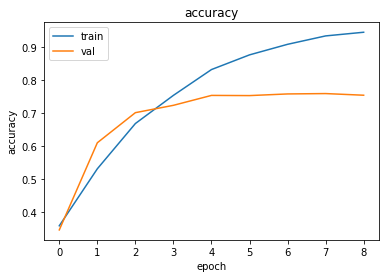

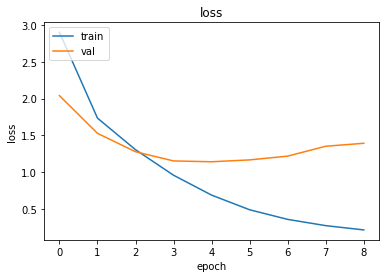

In [ ]:
visualize_train(history_dense)

In [ ]:
model_dense.predict(tfidfv_test_20k_dense)

array([[3.8337163e-08, 6.6211287e-05, 6.6562785e-07, ..., 7.8081868e-08,
        2.9930434e-13, 3.5483660e-13],
       [2.1454666e-03, 2.3951123e-05, 8.6771314e-07, ..., 3.0395728e-07,
        4.7251686e-10, 3.0145038e-09],
       [3.7861167e-04, 6.4455390e-01, 6.5269422e-05, ..., 3.5336872e-10,
        1.1818294e-11, 2.4564758e-12],
       ...,
       [7.4041373e-09, 4.1606970e-04, 1.1599026e-06, ..., 1.7829485e-08,
        8.5027222e-13, 2.3323981e-13],
       [2.6192386e-03, 1.6399663e-02, 3.9497812e-04, ..., 2.1957287e-05,
        4.2363364e-08, 7.0494359e-08],
       [2.9825060e-05, 8.1345715e-02, 5.0290156e-02, ..., 1.0460284e-06,
        9.7303445e-09, 2.6015601e-10]], dtype=float32)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import pair_confusion_matrix

print(classification_report(y_test_20k, model_dense.predict(tfidfv_test_20k_dense).argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.47      0.67      0.55        12
           1       0.66      0.73      0.69       105
           2       0.29      0.30      0.29        20
           3       0.93      0.89      0.91       813
           4       0.78      0.88      0.83       474
           5       0.00      0.00      0.00         5
           6       0.80      0.29      0.42        14
           7       0.00      0.00      0.00         3
           8       0.50      0.63      0.56        38
           9       0.95      0.76      0.84        25
          10       0.79      0.77      0.78        30
          11       0.80      0.57      0.66        83
          12       0.33      0.08      0.12        13
          13       0.42      0.46      0.44        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.59      0.74      0.65        99
          17       0.09    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def graph_confusion_matrix(model, x_test, y_test): # classes_name:
  df_cm = pd.DataFrame(confusion_matrix(y_test, model.predict(x_test).argmax(axis=1))) # index=classes_name, columns=classes_name
  fig = plt.figure(figsize=(15,15))
  heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
  plt.ylabel('label')
  plt.xlabel('predicted value')

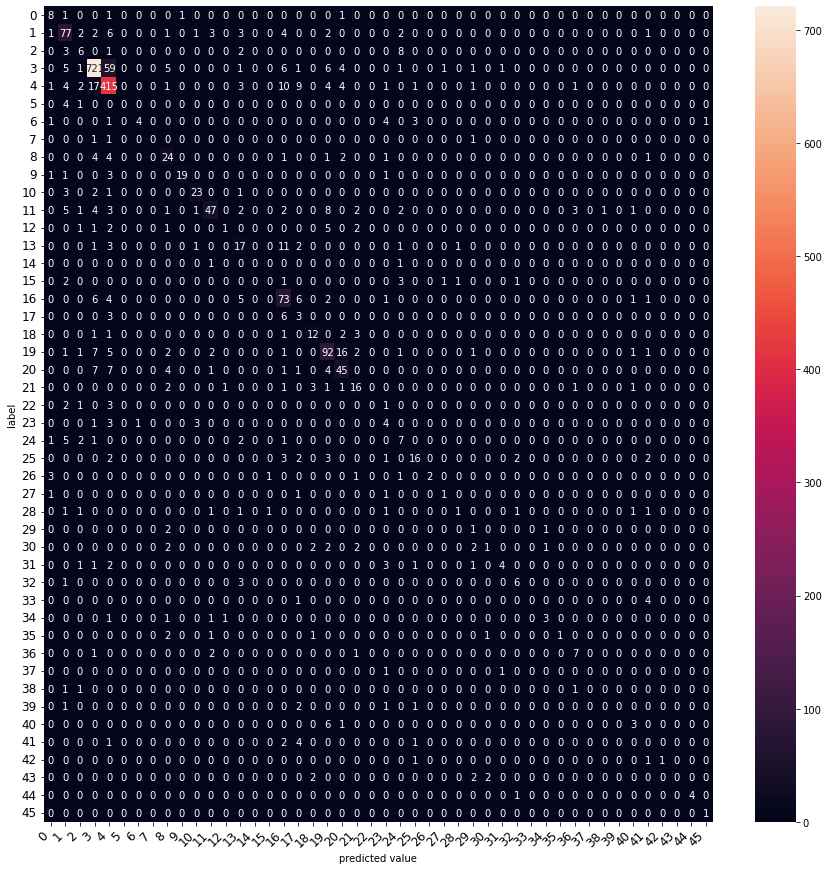

In [ ]:
graph_confusion_matrix(model_dense, tfidfv_test_20k_dense, y_test_20k)

### 회고
필사한 부분과 노드와 비교해가며 이해하려고 노력했다.벡터화와 다양한 머신러닝을 한곳에 넣어서 분석하는법을 배웠고 이해하였음. 확실히 복사 붙여넣기 하지않고 직접 다 쳐보니까 흐름을 읽고 이해하는데 훨씬 좋았다. 스스로 다 하지는 못하였지만 그래도 많은 부분을 알게 되어서 나름 만족한다. 코랩으로 했는데 올리니까 코드 결과가 안나오고 시각화만 나와서 주피터로 다시 했는데 거의 다 됐는데 서버 오류로 끊김...다시 한번더 했는데 같은곳에서 똑같이 또 연결이 끊김...... 데드커널 뜨면서 안된다. 시간 낭비 오지게함... 시간이 부족해서 다 못돌리는데 무슨 뷰어로 보면 코드 결과값도 볼수있다고 그걸로 보신다고 해서 처음했었던 코랩으로 다시 올리려고함